In [12]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling 

In [5]:
#### imports #### 

import tweepy
import json
import pandas as pd
from datetime import datetime
from datetime import timedelta
# pip install tweet-preprocessor
import preprocessor as pre  
import regex as re
import time
import configparser



#### Functions #### 
# export these into another file later 


# Function: preprocess tweet text
def cleantweet(tweet):
    #https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e
    #additional cleaning and parsing can be done 
    cleantweet = pre.clean(tweet)
    cleantweet = cleantweet.lower()
    cleantweet = re.sub('\d+', '', cleantweet)
    cleantweet = re.sub(r'[^\w\s]', '', cleantweet)  
    return cleantweet


# Function: identify tweet quality
def tweetquality(user_verified, favorite_count, retweet_count):
    if user_verified == True or favorite_count > 100 or retweet_count > 10:
        return True
    else:
        return False

# Function: twitter search pagination and rate limit handling
def limit_handled(cursor):
    while True:
        try:
            yield cursor.next()
        except StopIteration:
            break
        except tweepy.error:
            print('Reached rate limit. Sleeping for >15 minutes')
            time.sleep(15 * 61)



# Function: obtain query list from ticker list
def getqueries(tickers): #returns a list of query strings
    queries = []
    for ticker in tickers:
        querylist = []
        querylist.append('$'+ticker)
        othertickers=[]
        [othertickers.append(t) for t in tickers]
        othertickers.remove(ticker)
        for otherticker in othertickers:
            querylist.append(' -$'+otherticker) 
        tickerquery = ''.join([str(q) for q in querylist]) + ' -filter:retweets' #Exclude retweets
        queries.append(tickerquery)
    return queries



def get_tweets(query, since_id, until_date, max_tweets):
    search = limit_handled(tweepy.Cursor(api.search_tweets,
                                            q = query, 
                                            count = 100,
                                            tweet_mode='extended',
                                            lang='en',
                                            result_type="recent",
                                            ).items(max_tweets))

    dftweets = pd.DataFrame()
    #cycle through generator 
    for tweet in search:
        dftweets = pd.concat([dftweets, pd.json_normalize(tweet._json)])

    print(query,'\n','# tweets collected:', len(dftweets), '\n')

    try:
        dftweets['full_text_preprocessed'] = dftweets.apply(lambda row : cleantweet(row['full_text']), axis = 1)
        dftweets['quality'] = dftweets.apply(lambda row : tweetquality(row['user.verified'], row['favorite_count'], row['retweet_count']), axis = 1)
        dftweets['num_cashtags'] = dftweets.apply(lambda row : str(row['entities.symbols']).count('text'), axis = 1)
        dftweets['ticker'] = dftweets.apply(lambda row : query.split()[0], axis = 1)
        dftweets['query_params'] = dftweets.apply(lambda row : 'query:'+query+' since_id:'+str(since_id)+' until_date:'+str(until_date)+' max_tweets:'+str(max_tweets), axis = 1)
        #apply filter
        dftweets = dftweets[dftweets.num_cashtags == 1]
        return dftweets
            
    except Exception:
        #for debugging purposes
        print('\n', 'preprocessing broke!!!!!', '\n')
    finally:
        print('# tweets (filtered):',len(dftweets),'\n') 


#### Data Extraction ####


#will be provided by scoping algorithm 
tickers = tickers = list(set(['SPY','TSLA','PYPL', 'GME', 'VIX', 'AMD', 'F',
                              'BBBY', 'NFLX', 'NVDA', 'AAPL', 'INTC', 'FSR', 
                              'QQQ', 'TLRY', 'MSFT', 'TWTR', 'SNAP', 'HOOD', 
                              'WMT', 'PTON', 'WISH', 'CPRX', 'AMC', 'SNDL', 
                              'AMZN', 'DIS', 'NIO', 'FB', 'NFLX', 'LCID', 'NVDA']))

#parameters
max_tweets = 2000 #max per ticker 

print('tickers:', tickers)
print('max_tweets:', max_tweets, '\n')

# Set date/time parameters
cur_time_utc = datetime.utcnow().replace(microsecond=0)
until_date = cur_time_utc.strftime("%Y-%m-%d") #"2022-04-03"#"2022-04-25"#
from_date =  cur_time_utc - timedelta(days=1) #"2022-04-02"#"2022-04-24"#
from_date = from_date.strftime("%Y-%m-%d")

print('from date:', from_date) 
print('until date:', until_date, '\n')

#Config
config = configparser.ConfigParser()
config_path = r"/Users/dennis/Desktop/wisdmai/Data/.Archive/Twitter/config.ini"
config.read(config_path)

api_key = config['twitter']['api_key']
api_key_secret = config['twitter']['api_key_secret']

access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']


# API Authentication
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

#wrapper for Twitter API 
api = tweepy.API(auth, wait_on_rate_limit=True)

#get ticker queries 
queries = getqueries(tickers)
print('first queury:', queries[0], '\n')


# Find the last tweet id for from_date (need this to filter on from_date)
search_since_id = limit_handled(tweepy.Cursor(api.search_tweets, 
                                                q = 'A', #query does not matter
                                                tweet_mode = 'extended', 
                                                lang = 'en', 
                                                result_type = 'recent', 
                                                until = from_date
                                                ).items(1))

since_id  = [tweet._json['id'] for tweet in search_since_id][0]
print('since last tweet id:', since_id, '\n')

#tweets dataframe for all tweets (unfiltered) - might be able to store seperately 
dftweets = pd.DataFrame()
#pulling tweets 


for query in queries:
    new_tweets = get_tweets(query, since_id, until_date, max_tweets)
    dftweets = pd.concat([dftweets, new_tweets], axis = 0, ignore_index = True)



#### Data Exportation #### 
# change code to send to database once developed 

export_df = dftweets[['ticker',
            'created_at',
            'full_text_preprocessed',
            'user.verified',
            'favorite_count',
            'retweet_count',
            'quality',
            'entities.symbols',
            'num_cashtags'
            ,'query_params', 
            'user.followers_count'
            ]].copy() 


export_path = r"C:\Users\Dennis\Desktop\dftweets.csv"
export_df.to_csv(export_path)




tickers: ['WISH', 'WMT', 'TLRY', 'QQQ', 'NIO', 'GME', 'BBBY', 'CPRX', 'F', 'TWTR', 'PTON', 'TSLA', 'SNDL', 'DIS', 'AMC', 'AMZN', 'SPY', 'SNAP', 'NFLX', 'LCID', 'MSFT', 'PYPL', 'HOOD', 'INTC', 'NVDA', 'FSR', 'VIX', 'AMD', 'AAPL', 'FB']
max_tweets: 2000 

from date: 2022-11-30
until date: 2022-12-01 

first queury: $WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$BBBY -$CPRX -$F -$TWTR -$PTON -$TSLA -$SNDL -$DIS -$AMC -$AMZN -$SPY -$SNAP -$NFLX -$LCID -$MSFT -$PYPL -$HOOD -$INTC -$NVDA -$FSR -$VIX -$AMD -$AAPL -$FB -filter:retweets 

since last tweet id: 1597742201035161600 

$WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$BBBY -$CPRX -$F -$TWTR -$PTON -$TSLA -$SNDL -$DIS -$AMC -$AMZN -$SPY -$SNAP -$NFLX -$LCID -$MSFT -$PYPL -$HOOD -$INTC -$NVDA -$FSR -$VIX -$AMD -$AAPL -$FB -filter:retweets 
 # tweets collected: 635 

# tweets (filtered): 543 

$WMT -$WISH -$TLRY -$QQQ -$NIO -$GME -$BBBY -$CPRX -$F -$TWTR -$PTON -$TSLA -$SNDL -$DIS -$AMC -$AMZN -$SPY -$SNAP -$NFLX -$LCID -$MSFT -$PYPL -$HOOD -$INTC -$NVDA

Rate limit reached. Sleeping for: 408


$TSLA -$WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$BBBY -$CPRX -$F -$TWTR -$PTON -$SNDL -$DIS -$AMC -$AMZN -$SPY -$SNAP -$NFLX -$LCID -$MSFT -$PYPL -$HOOD -$INTC -$NVDA -$FSR -$VIX -$AMD -$AAPL -$FB -filter:retweets 
 # tweets collected: 2000 

# tweets (filtered): 1717 

$SNDL -$WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$BBBY -$CPRX -$F -$TWTR -$PTON -$TSLA -$DIS -$AMC -$AMZN -$SPY -$SNAP -$NFLX -$LCID -$MSFT -$PYPL -$HOOD -$INTC -$NVDA -$FSR -$VIX -$AMD -$AAPL -$FB -filter:retweets 
 # tweets collected: 872 

# tweets (filtered): 612 

$DIS -$WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$BBBY -$CPRX -$F -$TWTR -$PTON -$TSLA -$SNDL -$AMC -$AMZN -$SPY -$SNAP -$NFLX -$LCID -$MSFT -$PYPL -$HOOD -$INTC -$NVDA -$FSR -$VIX -$AMD -$AAPL -$FB -filter:retweets 
 # tweets collected: 2000 

# tweets (filtered): 1812 

$AMC -$WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$BBBY -$CPRX -$F -$TWTR -$PTON -$TSLA -$SNDL -$DIS -$AMZN -$SPY -$SNAP -$NFLX -$LCID -$MSFT -$PYPL -$HOOD -$INTC -$NVDA -$FSR -$VIX -$AMD -$AAPL -$FB -fil

Rate limit reached. Sleeping for: 355


$MSFT -$WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$BBBY -$CPRX -$F -$TWTR -$PTON -$TSLA -$SNDL -$DIS -$AMC -$AMZN -$SPY -$SNAP -$NFLX -$LCID -$PYPL -$HOOD -$INTC -$NVDA -$FSR -$VIX -$AMD -$AAPL -$FB -filter:retweets 
 # tweets collected: 2000 

# tweets (filtered): 1399 

$PYPL -$WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$BBBY -$CPRX -$F -$TWTR -$PTON -$TSLA -$SNDL -$DIS -$AMC -$AMZN -$SPY -$SNAP -$NFLX -$LCID -$MSFT -$HOOD -$INTC -$NVDA -$FSR -$VIX -$AMD -$AAPL -$FB -filter:retweets 
 # tweets collected: 1105 

# tweets (filtered): 996 

$HOOD -$WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$BBBY -$CPRX -$F -$TWTR -$PTON -$TSLA -$SNDL -$DIS -$AMC -$AMZN -$SPY -$SNAP -$NFLX -$LCID -$MSFT -$PYPL -$INTC -$NVDA -$FSR -$VIX -$AMD -$AAPL -$FB -filter:retweets 
 # tweets collected: 688 

# tweets (filtered): 582 

$INTC -$WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$BBBY -$CPRX -$F -$TWTR -$PTON -$TSLA -$SNDL -$DIS -$AMC -$AMZN -$SPY -$SNAP -$NFLX -$LCID -$MSFT -$PYPL -$HOOD -$NVDA -$FSR -$VIX -$AMD -$AAPL -$FB -filt

In [6]:
export_df.shape

(37110, 11)

In [7]:
export_df.head()

,ticker,created_at,full_text_preprocessed,user.verified,favorite_count,retweet_count,quality,entities.symbols,num_cashtags,query_params,user.followers_count
0,$WISH,Thu Dec 01 00:03:48 +0000 2022,wish is better stock and ecommerce platform,False,0,0,False,"[{'text': 'WISH', 'indices': [17, 22]}]",1,query:$WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$B...,30
1,$WISH,Wed Nov 30 22:45:44 +0000 2022,wish i made trading in the first hour of mark...,False,0,0,False,"[{'text': 'WISH', 'indices': [0, 5]}]",1,query:$WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$B...,4
2,$WISH,Wed Nov 30 22:37:40 +0000 2022,wish all these levels posted ahead of time bef...,False,0,0,False,"[{'text': 'WISH', 'indices': [0, 5]}]",1,query:$WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$B...,4
3,$WISH,Wed Nov 30 22:20:06 +0000 2022,wish i made trading in the first hour of mark...,False,0,0,False,"[{'text': 'wish', 'indices': [0, 5]}]",1,query:$WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$B...,6
4,$WISH,Wed Nov 30 22:10:08 +0000 2022,wish i made trading in the first hour of mark...,False,0,0,False,"[{'text': 'WISH', 'indices': [0, 5]}]",1,query:$WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$B...,6


In [13]:
analyser = SentimentIntensityAnalyzer()

In [14]:
def add_sentiment(df): 
    content = df['full_text_preprocessed'].copy().values 
    sentiments, scores = [], []
    for text in content:
        results = analyser.polarity_scores(text)
        del results['compound'] 

        sentiment = max(results, key = results.get) 
        score = results[sentiment]  

        sentiments = np.append(sentiments, sentiment) 
        scores = np.append(scores, score)

    new_df = df.copy() 
    new_df['sentiment'] = sentiments 
    new_df['sentiment_pscore'] = scores 

    return new_df

In [15]:
all_tweets = add_sentiment(export_df)

In [16]:
all_tweets.head()

,ticker,created_at,full_text_preprocessed,user.verified,favorite_count,retweet_count,quality,entities.symbols,num_cashtags,query_params,user.followers_count,sentiment,sentiment_pscore
0,$WISH,Thu Dec 01 00:03:48 +0000 2022,wish is better stock and ecommerce platform,False,0,0,False,"[{'text': 'WISH', 'indices': [17, 22]}]",1,query:$WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$B...,30,pos,0.528
1,$WISH,Wed Nov 30 22:45:44 +0000 2022,wish i made trading in the first hour of mark...,False,0,0,False,"[{'text': 'WISH', 'indices': [0, 5]}]",1,query:$WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$B...,4,neu,0.803
2,$WISH,Wed Nov 30 22:37:40 +0000 2022,wish all these levels posted ahead of time bef...,False,0,0,False,"[{'text': 'WISH', 'indices': [0, 5]}]",1,query:$WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$B...,4,neu,0.803
3,$WISH,Wed Nov 30 22:20:06 +0000 2022,wish i made trading in the first hour of mark...,False,0,0,False,"[{'text': 'wish', 'indices': [0, 5]}]",1,query:$WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$B...,6,neu,0.803
4,$WISH,Wed Nov 30 22:10:08 +0000 2022,wish i made trading in the first hour of mark...,False,0,0,False,"[{'text': 'WISH', 'indices': [0, 5]}]",1,query:$WISH -$WMT -$TLRY -$QQQ -$NIO -$GME -$B...,6,neu,0.803


In [17]:
all_tweets['len_tweet'] = [len(i) for i in all_tweets['full_text_preprocessed'].values]

# Simple Clustering

In [18]:
cluster_df = all_tweets[['sentiment_pscore', 'favorite_count', 'retweet_count', 'user.followers_count', 'len_tweet']].copy()
cluster_df.head()

,sentiment_pscore,favorite_count,retweet_count,user.followers_count,len_tweet
0,0.528,0,0,30,43
1,0.803,0,0,4,61
2,0.803,0,0,4,67
3,0.803,0,0,6,59
4,0.803,0,0,6,59


In [19]:
kmeans = KMeans(n_clusters= 5, random_state = 11) 
kmeans.fit(cluster_df)
labels = kmeans.labels_
cluster_df['cluster'] = labels
cluster_df

,sentiment_pscore,favorite_count,retweet_count,user.followers_count,len_tweet,cluster
0,0.528,0,0,30,43,0
1,0.803,0,0,4,61,0
2,0.803,0,0,4,67,0
3,0.803,0,0,6,59,0
4,0.803,0,0,6,59,0
...,...,...,...,...,...,...
37105,0.679,14,1,549,232,0
37106,0.815,15,0,549,64,0
37107,1.000,0,0,194,68,0
37108,0.795,0,0,8,42,0


In [20]:
#reduce the dimension 5 to 2 dimensions to vizualise the dataset 
data_embed = TSNE(n_components=2, perplexity=50, verbose=2, method='barnes_hut').fit_transform(cluster_df.to_numpy())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 37110 samples in 0.058s...
[t-SNE] Computed neighbors for 37110 samples in 2.756s...
[t-SNE] Computed conditional probabilities for sample 1000 / 37110
[t-SNE] Computed conditional probabilities for sample 2000 / 37110
[t-SNE] Computed conditional probabilities for sample 3000 / 37110
[t-SNE] Computed conditional probabilities for sample 4000 / 37110
[t-SNE] Computed conditional probabilities for sample 5000 / 37110
[t-SNE] Computed conditional probabilities for sample 6000 / 37110
[t-SNE] Computed conditional probabilities for sample 7000 / 37110
[t-SNE] Computed conditional probabilities for sample 8000 / 37110
[t-SNE] Computed conditional probabilities for sample 9000 / 37110
[t-SNE] Computed conditional probabilities for sample 10000 / 37110
[t-SNE] Computed conditional probabilities for sample 11000 / 37110
[t-SNE] Computed conditional probabilities for sample 12000 / 37110
[t-SNE] Computed conditional probabilities for sa

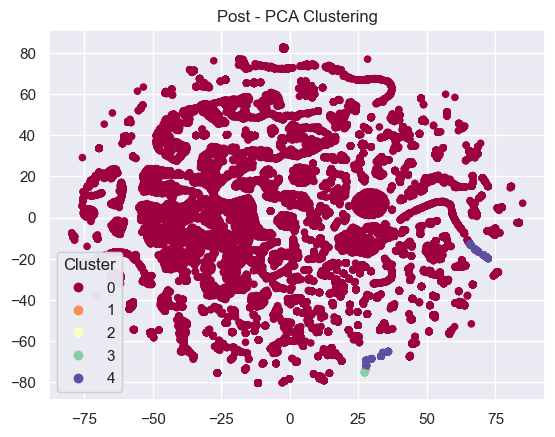

In [21]:
x, y = data_embed[:, 0], data_embed[:, 1]


fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=labels, s=20 ,cmap="Spectral")

legend = ax.legend(*scatter.legend_elements(num=4),
                    loc="lower left", title="Cluster")

ax.add_artist(legend)
plt.title("Post - PCA Clustering");

# Clustering w/ Additional Features 

In [22]:
all_tweets.columns

Index(['ticker', 'created_at', 'full_text_preprocessed', 'user.verified',
       'favorite_count', 'retweet_count', 'quality', 'entities.symbols',
       'num_cashtags', 'query_params', 'user.followers_count', 'sentiment',
       'sentiment_pscore', 'len_tweet'],
      dtype='object')

In [23]:
cluster_df = all_tweets[['sentiment_pscore','sentiment','favorite_count', 'retweet_count', 'user.followers_count', 'len_tweet', 'quality', 'user.verified', 'ticker']].copy()
cluster_df.head()

,sentiment_pscore,sentiment,favorite_count,retweet_count,user.followers_count,len_tweet,quality,user.verified,ticker
0,0.528,pos,0,0,30,43,False,False,$WISH
1,0.803,neu,0,0,4,61,False,False,$WISH
2,0.803,neu,0,0,4,67,False,False,$WISH
3,0.803,neu,0,0,6,59,False,False,$WISH
4,0.803,neu,0,0,6,59,False,False,$WISH


In [24]:
dummies = pd.get_dummies(data = cluster_df, columns = ['ticker', 'sentiment', 'quality', 'user.verified'])
dummies.columns

Index(['sentiment_pscore', 'favorite_count', 'retweet_count',
       'user.followers_count', 'len_tweet', 'ticker_$AAPL', 'ticker_$AMC',
       'ticker_$AMD', 'ticker_$AMZN', 'ticker_$BBBY', 'ticker_$CPRX',
       'ticker_$DIS', 'ticker_$F', 'ticker_$FB', 'ticker_$FSR', 'ticker_$GME',
       'ticker_$HOOD', 'ticker_$INTC', 'ticker_$LCID', 'ticker_$MSFT',
       'ticker_$NFLX', 'ticker_$NIO', 'ticker_$NVDA', 'ticker_$PTON',
       'ticker_$PYPL', 'ticker_$QQQ', 'ticker_$SNAP', 'ticker_$SNDL',
       'ticker_$SPY', 'ticker_$TLRY', 'ticker_$TSLA', 'ticker_$TWTR',
       'ticker_$VIX', 'ticker_$WISH', 'ticker_$WMT', 'sentiment_neg',
       'sentiment_neu', 'sentiment_pos', 'quality_False', 'quality_True',
       'user.verified_False', 'user.verified_True'],
      dtype='object')

In [25]:
cluster_df = dummies.drop(['quality_False', 'user.verified_False' ], axis = 1)
cluster_df.head()

,sentiment_pscore,favorite_count,retweet_count,user.followers_count,len_tweet,ticker_$AAPL,ticker_$AMC,ticker_$AMD,ticker_$AMZN,ticker_$BBBY,...,ticker_$TSLA,ticker_$TWTR,ticker_$VIX,ticker_$WISH,ticker_$WMT,sentiment_neg,sentiment_neu,sentiment_pos,quality_True,user.verified_True
0,0.528,0,0,30,43,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,0.803,0,0,4,61,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0.803,0,0,4,67,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,0.803,0,0,6,59,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0.803,0,0,6,59,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [26]:
kmeans = KMeans(n_clusters= 5, random_state = 11) 
kmeans.fit(cluster_df)
labels = kmeans.labels_
cluster_df['cluster'] = labels
cluster_df

,sentiment_pscore,favorite_count,retweet_count,user.followers_count,len_tweet,ticker_$AAPL,ticker_$AMC,ticker_$AMD,ticker_$AMZN,ticker_$BBBY,...,ticker_$TWTR,ticker_$VIX,ticker_$WISH,ticker_$WMT,sentiment_neg,sentiment_neu,sentiment_pos,quality_True,user.verified_True,cluster
0,0.528,0,0,30,43,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0.803,0,0,4,61,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,0.803,0,0,4,67,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,0.803,0,0,6,59,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,0.803,0,0,6,59,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37105,0.679,14,1,549,232,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
37106,0.815,15,0,549,64,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
37107,1.000,0,0,194,68,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
37108,0.795,0,0,8,42,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [27]:
data_embed = TSNE(n_components=2, perplexity=50, verbose=2, method='barnes_hut').fit_transform(cluster_df.to_numpy())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 37110 samples in 0.010s...
[t-SNE] Computed neighbors for 37110 samples in 5.250s...
[t-SNE] Computed conditional probabilities for sample 1000 / 37110
[t-SNE] Computed conditional probabilities for sample 2000 / 37110
[t-SNE] Computed conditional probabilities for sample 3000 / 37110
[t-SNE] Computed conditional probabilities for sample 4000 / 37110
[t-SNE] Computed conditional probabilities for sample 5000 / 37110
[t-SNE] Computed conditional probabilities for sample 6000 / 37110
[t-SNE] Computed conditional probabilities for sample 7000 / 37110
[t-SNE] Computed conditional probabilities for sample 8000 / 37110
[t-SNE] Computed conditional probabilities for sample 9000 / 37110
[t-SNE] Computed conditional probabilities for sample 10000 / 37110
[t-SNE] Computed conditional probabilities for sample 11000 / 37110
[t-SNE] Computed conditional probabilities for sample 12000 / 37110
[t-SNE] Computed conditional probabilities for sa

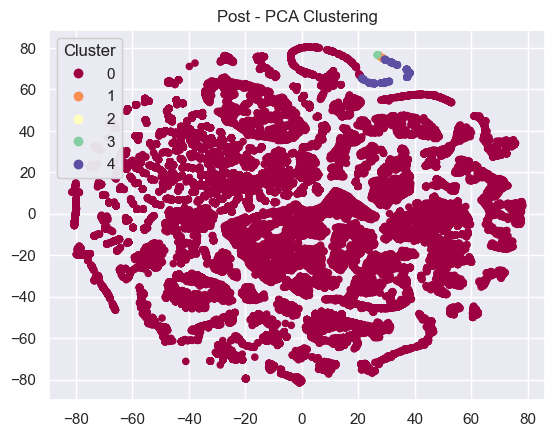

In [28]:
x, y = data_embed[:, 0], data_embed[:, 1]

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=labels, s=20 ,cmap="Spectral")

legend = ax.legend(*scatter.legend_elements(num=4),
                    loc="upper left", title="Cluster")

ax.add_artist(legend)
plt.title("Post - PCA Clustering");

# Clustering w/ Normalization

In [29]:
cluster_df = cluster_df.drop(['cluster'], axis =1)
cluster_df

,sentiment_pscore,favorite_count,retweet_count,user.followers_count,len_tweet,ticker_$AAPL,ticker_$AMC,ticker_$AMD,ticker_$AMZN,ticker_$BBBY,...,ticker_$TSLA,ticker_$TWTR,ticker_$VIX,ticker_$WISH,ticker_$WMT,sentiment_neg,sentiment_neu,sentiment_pos,quality_True,user.verified_True
0,0.528,0,0,30,43,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,0.803,0,0,4,61,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0.803,0,0,4,67,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,0.803,0,0,6,59,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0.803,0,0,6,59,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37105,0.679,14,1,549,232,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
37106,0.815,15,0,549,64,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
37107,1.000,0,0,194,68,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
37108,0.795,0,0,8,42,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [30]:
norm_cluster_df = pd.DataFrame(normalize(cluster_df))
norm_cluster_df.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.010066,0.0,0.0,0.571945,0.819787,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.019065,0.0,0.0,0.000000,0.019065,0.0,0.0
1,0.013131,0.0,0.0,0.065410,0.997504,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.016353,0.0,0.0,0.016353,0.000000,0.0,0.0
2,0.011960,0.0,0.0,0.059578,0.997930,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.014894,0.0,0.0,0.014894,0.000000,0.0,0.0
3,0.013535,0.0,0.0,0.101135,0.994495,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.016856,0.0,0.0,0.016856,0.000000,0.0,0.0
4,0.013535,0.0,0.0,0.101135,0.994495,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.016856,0.0,0.0,0.016856,0.000000,0.0,0.0


In [31]:
kmeans = KMeans(n_clusters= 5, random_state = 11) 
kmeans.fit(norm_cluster_df)
labels =  kmeans.labels_
norm_cluster_df['cluster'] = labels

In [32]:
norm_data_embed = TSNE(n_components=2, perplexity=50, verbose=2, method='barnes_hut').fit_transform(norm_cluster_df.to_numpy())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 37110 samples in 0.011s...
[t-SNE] Computed neighbors for 37110 samples in 8.125s...
[t-SNE] Computed conditional probabilities for sample 1000 / 37110
[t-SNE] Computed conditional probabilities for sample 2000 / 37110
[t-SNE] Computed conditional probabilities for sample 3000 / 37110
[t-SNE] Computed conditional probabilities for sample 4000 / 37110
[t-SNE] Computed conditional probabilities for sample 5000 / 37110
[t-SNE] Computed conditional probabilities for sample 6000 / 37110
[t-SNE] Computed conditional probabilities for sample 7000 / 37110
[t-SNE] Computed conditional probabilities for sample 8000 / 37110
[t-SNE] Computed conditional probabilities for sample 9000 / 37110
[t-SNE] Computed conditional probabilities for sample 10000 / 37110
[t-SNE] Computed conditional probabilities for sample 11000 / 37110
[t-SNE] Computed conditional probabilities for sample 12000 / 37110
[t-SNE] Computed conditional probabilities for sa

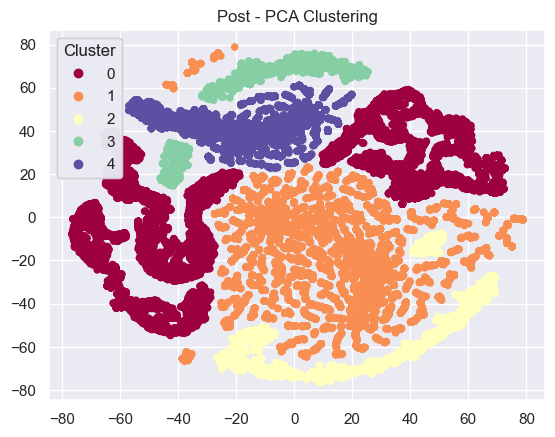

In [33]:
x, y = norm_data_embed[:, 0], norm_data_embed[:, 1]


fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=labels, s=20 ,cmap="Spectral")

legend = ax.legend(*scatter.legend_elements(num=4),
                    loc="upper left", title="Cluster")

ax.add_artist(legend)
plt.title("Post - PCA Clustering");
